In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 路徑
load_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_slim2.4G.csv"

# 讀取資料
df = pd.read_csv(load_path)
print("✅ 讀取成功，資料維度：", df.shape)

# 保留 index 方便對照
df["orig_index"] = df.index

# 特徵分割
amp = df.iloc[:, 0:48].values
labels = df["Label"].values
orig_idx = df["orig_index"].values

# 切 train / temp
amp_train, amp_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    amp, labels, orig_idx, test_size=0.3, random_state=42
)

# 切 val / test
amp_val, amp_test,y_val, y_test, idx_val, idx_test = train_test_split(
    amp_temp, y_temp, idx_temp, test_size=2/3, random_state=42
)

# 檢查一筆對不對齊
i = 0
print("✅ [amp] 切出來：", amp_train[i][:5])
print("✅ [amp] 原始 df：", df.iloc[int(idx_train[i]), 0:5].values)


print("✅ [label] 切出來：", y_train[i])
print("✅ [label] 原始 df：", df.iloc[int(idx_train[i])]["Label"])

✅ 讀取成功，資料維度： (19649, 53)
✅ [amp] 切出來： [618.80934059 592.62551413 566.35059813 537.837336   496.88328609]
✅ [amp] 原始 df： [618.80934059 592.62551413 566.35059813 537.837336   496.88328609]
✅ [label] 切出來： 4
✅ [label] 原始 df： 4.0


In [5]:
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_oh = encoder.transform(np.array(y_val).reshape(-1, 1))
y_test_oh = encoder.transform(np.array(y_test).reshape(-1, 1))

In [65]:
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

In [66]:
labels = np.argmax(y_test, axis=1) + 1

print("最大 label:", np.max(labels))
print("最小 label:", np.min(labels))


最大 label: 49
最小 label: 1


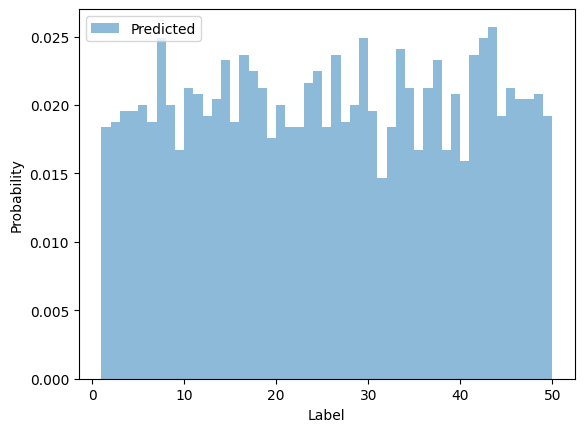

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 y_test 是 one-hot label, shape (N, 49)
labels = np.argmax(y_test, axis=1) + 1  # 得到 1~49 的 label

plt.hist(labels, bins=49, range=(1, 50), density=True, alpha=0.5, label='Predicted')
plt.xlabel('Label')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [68]:
mean_error, _ = compute_mean_distance_error(np.argmax(y_test, axis=1)+1, np.argmax(y_pred, axis=1)+1, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.04648341079321986


# 2.4 G

In [118]:
#12/07
base_path2 = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1207_phone/20MHz/csv/"

In [119]:
reference_points2 = {}

spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path2 = os.path.join(base_path2, f"reference_point_{ref_id}.xlsx")
    reference_points2[folder_path2] = (ref_id, coord)

In [120]:
data, rp_labels, coord_labels = load_data(reference_points2)
amp_data = np.array(data.iloc[:, :48])  
phase_data = np.array(data.iloc[:, 48:-2]) 

In [83]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(np.array(rp_labels).reshape(-1, 1))

In [121]:
amp_train, amp_temp, y_train, y_temp = train_test_split(amp_data, one_hot_labels, test_size=0.3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [122]:
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(amp_train, y_train)
y_pred = knn.predict(amp_test)

In [123]:
accuracy_score(y_test, y_pred)

0.9169054441260746

In [124]:
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

In [125]:
mean_error, _ = compute_mean_distance_error(np.argmax(y_test, axis=1)+1, np.argmax(y_pred, axis=1)+1, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.3730696423008712


In [126]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIDataset(amp_train, y_train)
val_dataset = CSIDataset(amp_val, y_val)
test_dataset = CSIDataset(amp_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=49):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = 128 * 12  # 48 -> 24 -> 12 after pooling

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Ensure input is in the shape (batch_size, channels, length)
        if x.dim() == 2:
            x = x.unsqueeze(1)

        if x.shape[1] != 1:
            x = x.permute(0, 2, 1)  # (batch_size, 1, 48)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

# Initialize the model
model = CNNClassifier(num_classes=49).to(device)

# Print model summary
summary(model, input_size=(1, 48))  # Input shape: (channels, length)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 48]             256
       BatchNorm1d-2               [-1, 64, 48]             128
         MaxPool1d-3               [-1, 64, 24]               0
            Conv1d-4              [-1, 128, 24]          24,704
       BatchNorm1d-5              [-1, 128, 24]             256
         MaxPool1d-6              [-1, 128, 12]               0
            Linear-7                  [-1, 128]         196,736
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 49]           3,185
Total params: 233,521
Trainable params: 233,521
Non-trainable params: 0
----------------------------------------------------------------
Input size 

In [116]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 你原本的 CNNClassifier (單 CSI 輸入) 定義（略）

# COORDINATES, compute_mean_distance_error 你的定義照舊

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 你原本的 CNNClassifier (單 CSI 輸入) 定義（略）

# COORDINATES, compute_mean_distance_error 你的定義照舊

num_runs = 5
epochs = 200
patience = 20

test_accs = []
test_mdes = []
all_run_errors = []
for run in range(1, num_runs + 1):
    print(f"\n=== Run {run}/{num_runs} ===")
    model = CNNClassifier(num_classes=49).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    counter = 0

    # === 主要修改從這裡開始 ===
    best_model_path = "best_model_tmp_24.pth"
    for epoch in range(epochs):
        model.train()
        for csi_inputs, labels in train_loader:
            csi_inputs, labels = csi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)
            optimizer.zero_grad()
            class_out = model(csi_inputs)
            loss = criterion(class_out, target_class)
            loss.backward()
            optimizer.step()

        # 驗證
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for csi_inputs, labels in val_loader:
                csi_inputs, labels = csi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out = model(csi_inputs)
                val_loss += criterion(class_out, target_class).item() * csi_inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # ---- 新增：儲存最佳模型 ----
            torch.save(model.state_dict(), best_model_path)
        else:
            counter += 1
            if counter >= patience:
                break
    # === 主要修改到這裡結束 ===

    # ---- 測試前載入最佳模型 ----
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for csi_inputs, labels in test_loader:
            csi_inputs, labels = csi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)
            class_out = model(csi_inputs)
            pred = torch.argmax(class_out, dim=1)
            all_pred.extend(pred.cpu().numpy())
            all_true.extend(target_class.cpu().numpy())

    y_true = np.array(all_true) + 1
    y_pred = np.array(all_pred) + 1
    acc = 100 * np.mean(y_true == y_pred)
    mde, error = compute_mean_distance_error(y_true, y_pred, COORDINATES)

    test_accs.append(acc)
    test_mdes.append(mde)
    all_run_errors.append(error)

    print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

os.makedirs("repeat_2_4/00", exist_ok=True)
df = pd.DataFrame({
    "run": list(range(1, num_runs+1)),
    "accuracy": test_accs,
    "mde": test_mdes
})
df.to_csv("repeat_2_4/00/csicls_results00_b2.csv", index=False)
# 儲存所有 error（長條格式）

# 儲存結果
errors_flat = []
for run_idx, errors in enumerate(all_run_errors):
    for sample_idx, e in enumerate(errors):
        errors_flat.append({
            "run": run_idx + 1,
            "sample_idx": sample_idx + 1,
            "error": e
        })
df_errors = pd.DataFrame(errors_flat)
os.makedirs("repeat_2_4/00", exist_ok=True)
df_errors.to_csv("repeat_2_4/00/csicls_all_errors00_b2.csv", index=False)




=== Run 1/5 ===
✅ Run 1: Acc = 93.86%, MDE = 0.2684

=== Run 2/5 ===
✅ Run 2: Acc = 94.27%, MDE = 0.2446

=== Run 3/5 ===
✅ Run 3: Acc = 93.98%, MDE = 0.2517

=== Run 4/5 ===
✅ Run 4: Acc = 94.27%, MDE = 0.2448

=== Run 5/5 ===
✅ Run 5: Acc = 94.31%, MDE = 0.2479


In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_DualHead(nn.Module):
    def __init__(self, num_classes=49, regression_dim=2):
        super(CNN_DualHead, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = 128 * 12  # 48 -> 24 -> 12 after pooling

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)

        # Two heads: classification & regression
        self.class_head = nn.Linear(64, num_classes)     # 分類 head
        self.reg_head = nn.Linear(64, regression_dim)    # 回歸 head (預設 2 維)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        if x.shape[1] != 1:
            x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        class_out = self.class_head(x)  # 分類輸出 (logits)
        reg_out = self.reg_head(x)      # 回歸輸出 (通常 2 維)

        return class_out, reg_out


In [ ]:
# def compute_mean_distance_error(y_true, y_pred, coordinates):
#     """
#     y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
#     coordinates: dict, label -> (x, y)
#     """
#     errors = []

#     for true_label, pred_label in zip(y_true, y_pred):
#         # 取出對應的座標
#         if true_label not in coordinates or pred_label not in coordinates:
#             # 若某個 label 不在座標字典內，就跳過（或視需求處理）
#             print(f"Label {true_label} or {pred_label} not in coordinates.")
#             continue
#         true_coord = np.array(coordinates[true_label])
#         pred_coord = np.array(coordinates[pred_label])
#         # 計算歐氏距離
#         error = np.linalg.norm(pred_coord - true_coord)
#         errors.append(error)
#     return np.mean(errors) , np.std(errors)

# COORDINATES = {
#     # 下邊界 (1-10 和 40-31)
#     1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
#     36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
#     # 左邊界 (1-11)
#     2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
#     6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
#     # 上邊界 (11-21)
#     12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
#     16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
#     20: (5.4, 6.0), 21: (6.0, 6.0),
#     # 右邊界 (21-31)
#     22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
#     26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
#     # 中間點 (41-49)
#     41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
#     44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
#     47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
# }

# def labels_to_coords(label_tensor, coord_dict):
#     coords = []
#     for label in label_tensor:
#         # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
#         coords.append(coord_dict[label.item() + 1])
#     return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

# # ---------- 3. 訓練設定 ----------
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion_cls  = nn.CrossEntropyLoss()
# criterion_reg  = nn.MSELoss()

# alphas   = np.arange(0.1, 1.1, 0.1)
# num_runs = 5
# epochs   = 200
# patience = 20

# summary_results = []

# # 假設 train_loader / val_loader / test_loader 僅回傳 (csi_inputs, labels)
# for alpha in alphas:
#     run_acc, run_mde, run_mde_std = [], [], []

#     print(f"\n[Alpha = {alpha:.1f}]  Start {num_runs} runs")
#     for run in range(1, num_runs + 1):
#         print(f"Run {run}/{num_runs}")
#         model = CNN_DualHead(num_classes=49).to(device)
#         optimzr = optim.Adam(model.parameters(), lr=1e-3)
#         sched   = optim.lr_scheduler.ReduceLROnPlateau(optimzr, 'min', 0.5, patience=15)
#         best_val, wait = float('inf'), 0

#         # ----- training with early-stop -----
#         for epoch in range(epochs):
#             model.train()
#             for csi_x, labels in train_loader:
#                 csi_x, labels = csi_x.to(device), labels.to(device)
#                 target = torch.argmax(labels, 1)

#                 cls_out, reg_out = model(csi_x)
#                 loss_cls = criterion_cls(cls_out, target)


#                 loss_reg = criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
#                 loss = loss_cls + alpha * loss_reg

#                 optimzr.zero_grad(); loss.backward(); optimzr.step()

#             # ----- validation -----
#             model.eval(); val_loss = 0
#             with torch.no_grad():
#                 for csi_x, labels in val_loader:
#                     csi_x, labels = csi_x.to(device), labels.to(device)
#                     target = torch.argmax(labels, 1)
#                     cls_out, reg_out = model(csi_x)
#                     v_loss = criterion_cls(cls_out, target) \
#                            + alpha * criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
#                     val_loss += v_loss.item() * csi_x.size(0)

#             val_loss /= len(val_loader.dataset)
#             sched.step(val_loss)

#             if val_loss < best_val:
#                 best_val, wait = val_loss, 0
#             else:
#                 wait += 1
#                 if wait >= patience:
#                     break

#         # ----- testing -----
#         model.eval(); y_true, y_pred = [], []
#         with torch.no_grad():
#             for csi_x, labels in test_loader:
#                 csi_x, labels = csi_x.to(device), labels.to(device)
#                 target = torch.argmax(labels, 1)
#                 cls_out, _ = model(csi_x)
#                 pred = torch.argmax(cls_out, 1)
#                 y_true.extend((target.cpu().numpy() + 1))   # 轉 1-index
#                 y_pred.extend((pred.cpu().numpy()   + 1))

#         acc            = 100 * np.mean(np.array(y_true) == np.array(y_pred))
#         mde_mean, mde_sd = compute_mean_distance_error(y_true, y_pred, COORDINATES)

#         run_acc.append(acc); run_mde.append(mde_mean); run_mde_std.append(mde_sd)
#         print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde_mean:.4f} ± {mde_sd:.4f}")

#     # ----- 儲存每個 α 的結果 -----
#     alpha_id = int(round(alpha * 10))
#     folder   = f"repeat_2_4/{alpha_id:02d}"
#     os.makedirs(folder, exist_ok=True)

#     pd.DataFrame({
#         'run':     range(1, num_runs + 1),
#         'accuracy':run_acc,
#         'mde':     run_mde,
#         'mde_std': run_mde_std
#     }).to_csv(f"{folder}/csi_cls_reg_results{alpha_id:02d}.csv", index=False)

#     summary_results.append({
#         'alpha':   alpha,
#         'avg_acc': np.mean(run_acc),
#         'std_acc': np.std(run_acc),
#         'avg_mde': np.mean(run_mde),
#         'std_mde': np.std(run_mde)
#     })

# # 最後整合各 α 統計
# summary_df = pd.DataFrame(summary_results)
# # summary_df.to_csv("csi_alpha_comparison_summary.csv", index=False)
# print("\n=== DONE ===")



[Alpha = 0.1]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 94.11%, MDE = 0.2424 ± 1.0790
Run 2/5
✅ Run 2: Acc = 95.17%, MDE = 0.2017 ± 1.0005
Run 3/5
✅ Run 3: Acc = 94.60%, MDE = 0.2195 ± 1.0255
Run 4/5
✅ Run 4: Acc = 95.01%, MDE = 0.1954 ± 0.9544
Run 5/5
✅ Run 5: Acc = 93.61%, MDE = 0.2535 ± 1.0842

[Alpha = 0.2]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 92.10%, MDE = 0.3284 ± 1.2420
Run 2/5
✅ Run 2: Acc = 92.43%, MDE = 0.3048 ± 1.1884
Run 3/5
✅ Run 3: Acc = 93.41%, MDE = 0.2711 ± 1.1290
Run 4/5
✅ Run 4: Acc = 95.13%, MDE = 0.1934 ± 0.9625
Run 5/5
✅ Run 5: Acc = 94.97%, MDE = 0.1995 ± 0.9704

[Alpha = 0.3]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 92.55%, MDE = 0.2797 ± 1.1185
Run 2/5
✅ Run 2: Acc = 94.76%, MDE = 0.2029 ± 0.9616
Run 3/5
✅ Run 3: Acc = 94.43%, MDE = 0.2215 ± 1.0224
Run 4/5
✅ Run 4: Acc = 94.76%, MDE = 0.1966 ± 0.9435
Run 5/5
✅ Run 5: Acc = 95.05%, MDE = 0.1924 ± 0.9396

[Alpha = 0.4]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 92.43%, MDE = 0.2959 ± 1.1608
Run 2/5
✅ Run 2: Acc = 93.12%, MDE =

In [ ]:
# def compute_mean_distance_error(y_true, y_pred, coordinates):
#     """
#     y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
#     coordinates: dict, label -> (x, y)
#     """
#     errors = []

#     for true_label, pred_label in zip(y_true, y_pred):
#         # 取出對應的座標
#         if true_label not in coordinates or pred_label not in coordinates:
#             # 若某個 label 不在座標字典內，就跳過（或視需求處理）
#             print(f"Label {true_label} or {pred_label} not in coordinates.")
#             continue
#         true_coord = np.array(coordinates[true_label])
#         pred_coord = np.array(coordinates[pred_label])
#         # 計算歐氏距離
#         error = np.linalg.norm(pred_coord - true_coord)
#         errors.append(error)
#     return np.mean(errors) , np.std(errors)



# # 這個給上面 "all_run_errors" 用，直接回傳所有error vector
# def compute_mean_distance_error_full(y_true, y_pred, coordinates):
#     errors = []
#     for true_label, pred_label in zip(y_true, y_pred):
#         if true_label not in coordinates or pred_label not in coordinates:
#             print(f"Label {true_label} or {pred_label} not in coordinates.")
#             continue
#         true_coord = np.array(coordinates[true_label])
#         pred_coord = np.array(coordinates[pred_label])
#         error = np.linalg.norm(pred_coord - true_coord)
#         errors.append(error)
#     return np.mean(errors), errors

# COORDINATES = {
#     # 下邊界 (1-10 和 40-31)
#     1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
#     36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
#     # 左邊界 (1-11)
#     2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
#     6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
#     # 上邊界 (11-21)
#     12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
#     16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
#     20: (5.4, 6.0), 21: (6.0, 6.0),
#     # 右邊界 (21-31)
#     22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
#     26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
#     # 中間點 (41-49)
#     41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
#     44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
#     47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
# }



# def labels_to_coords(label_tensor, coord_dict):
#     coords = []
#     for label in label_tensor:
#         # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
#         coords.append(coord_dict[label.item() + 1])
#     return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# # ---------- 3. 訓練設定 ----------
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion_cls  = nn.CrossEntropyLoss()
# criterion_reg  = nn.MSELoss()

# alphas   = np.arange(0.1, 1.1, 0.1)
# num_runs = 5
# epochs   = 200
# patience = 20

# summary_results = []



# for alpha in alphas:
#     run_acc, run_mde, run_mde_std = [], [], []
#     all_run_errors = []  # 每個 run 的 errors 都存進來

#     print(f"\n[Alpha = {alpha:.1f}]  Start {num_runs} runs")
#     for run in range(1, num_runs + 1):
#         print(f"Run {run}/{num_runs}")
#         model = CNN_DualHead(num_classes=49).to(device)
#         optimzr = optim.Adam(model.parameters(), lr=1e-3)
#         sched   = optim.lr_scheduler.ReduceLROnPlateau(optimzr, 'min', 0.5, patience=15)
#         best_val, wait = float('inf'), 0
#         best_model_path = "best_model_tmp.pth"

#         # ----- training with early-stop -----
#         for epoch in range(epochs):
#             model.train()
#             for csi_x, labels in train_loader:
#                 csi_x, labels = csi_x.to(device), labels.to(device)
#                 target = torch.argmax(labels, 1)

#                 cls_out, reg_out = model(csi_x)
#                 loss_cls = criterion_cls(cls_out, target)
#                 loss_reg = criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
#                 loss = loss_cls + alpha * loss_reg

#                 optimzr.zero_grad(); loss.backward(); optimzr.step()

#             # ----- validation -----
#             model.eval(); val_loss = 0
#             with torch.no_grad():
#                 for csi_x, labels in val_loader:
#                     csi_x, labels = csi_x.to(device), labels.to(device)
#                     target = torch.argmax(labels, 1)
#                     cls_out, reg_out = model(csi_x)
#                     v_loss = criterion_cls(cls_out, target) \
#                            + alpha * criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
#                     val_loss += v_loss.item() * csi_x.size(0)

#             val_loss /= len(val_loader.dataset)
#             sched.step(val_loss)

#             if val_loss < best_val:
#                 best_val, wait = val_loss, 0
#                 # --- save best model ---
#                 torch.save(model.state_dict(), best_model_path)
#             else:
#                 wait += 1
#                 if wait >= patience:
#                     break

#         # ----- 測試用最佳模型 -----
#         model.load_state_dict(torch.load(best_model_path))
#         model.eval()
#         y_true, y_pred, errors = [], [], []
#         with torch.no_grad():
#             for csi_x, labels in test_loader:
#                 csi_x, labels = csi_x.to(device), labels.to(device)
#                 target = torch.argmax(labels, 1)
#                 cls_out, _ = model(csi_x)
#                 pred = torch.argmax(cls_out, 1)
#                 y_true.extend((target.cpu().numpy() + 1))   # 轉 1-index
#                 y_pred.extend((pred.cpu().numpy()   + 1))

#         # 計算每一筆誤差
#         mde_mean, mde_sd = compute_mean_distance_error(y_true, y_pred, COORDINATES)
#         # 額外記錄所有 errors (逐筆)
#         _, err_vec = compute_mean_distance_error_full(y_true, y_pred, COORDINATES)  # <--- 見下說明

#         run_acc.append(100 * np.mean(np.array(y_true) == np.array(y_pred)))
#         run_mde.append(mde_mean)
#         run_mde_std.append(mde_sd)
#         all_run_errors.append(err_vec)

#         print(f"✅ Run {run}: Acc = {run_acc[-1]:.2f}%, MDE = {mde_mean:.4f} ± {mde_sd:.4f}")

#     # ===== 每個 alpha 儲存完整誤差 =====
#     alpha_id = int(round(alpha * 10))
#     folder   = f"repeat_2_4/{alpha_id:02d}"
#     os.makedirs(folder, exist_ok=True)

#     # 統計檔
#     pd.DataFrame({
#         'run':     range(1, num_runs + 1),
#         'accuracy':run_acc,
#         'mde':     run_mde,
#         'mde_std': run_mde_std
#     }).to_csv(f"{folder}/csi_cls_reg_results{alpha_id:02d}_b2.csv", index=False)

#     # 儲存所有誤差（長條格式）
#     errors_flat = []
#     for run_idx, errors in enumerate(all_run_errors):
#         for sample_idx, e in enumerate(errors):
#             errors_flat.append({
#                 "run": run_idx + 1,
#                 "sample_idx": sample_idx + 1,
#                 "error": e
#             })
#     pd.DataFrame(errors_flat).to_csv(f"{folder}/csi_cls_reg_all_errors{alpha_id:02d}_b2.csv", index=False)

#     summary_results.append({
#         'alpha':   alpha,
#         'avg_acc': np.mean(run_acc),
#         'std_acc': np.std(run_acc),
#         'avg_mde': np.mean(run_mde),
#         'std_mde': np.std(run_mde)
#     })

# # ... summary_results 統計照舊

# print("\n=== DONE ===")



[Alpha = 0.1]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 96.07%, MDE = 0.1639 ± 0.8937
Run 2/5
✅ Run 2: Acc = 95.54%, MDE = 0.1871 ± 0.9546
Run 3/5
✅ Run 3: Acc = 95.74%, MDE = 0.1785 ± 0.9352
Run 4/5
✅ Run 4: Acc = 96.32%, MDE = 0.1568 ± 0.8814
Run 5/5
✅ Run 5: Acc = 96.36%, MDE = 0.1550 ± 0.8784

[Alpha = 0.2]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 96.11%, MDE = 0.1667 ± 0.9067
Run 2/5
✅ Run 2: Acc = 96.11%, MDE = 0.1644 ± 0.8923
Run 3/5
✅ Run 3: Acc = 96.44%, MDE = 0.1525 ± 0.8656
Run 4/5
✅ Run 4: Acc = 96.40%, MDE = 0.1562 ± 0.8731
Run 5/5
✅ Run 5: Acc = 96.40%, MDE = 0.1597 ± 0.8924

[Alpha = 0.3]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 96.40%, MDE = 0.1508 ± 0.8545
Run 2/5
✅ Run 2: Acc = 96.36%, MDE = 0.1569 ± 0.8780
Run 3/5
✅ Run 3: Acc = 96.15%, MDE = 0.1593 ± 0.8840
Run 4/5
✅ Run 4: Acc = 96.23%, MDE = 0.1593 ± 0.8705
Run 5/5
✅ Run 5: Acc = 95.87%, MDE = 0.1752 ± 0.9210

[Alpha = 0.4]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 96.36%, MDE = 0.1575 ± 0.8749
Run 2/5
✅ Run 2: Acc = 95.99%, MDE =

In [ ]:
#測試CODE

In [129]:
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , np.std(errors)



# 這個給上面 "all_run_errors" 用，直接回傳所有error vector
def compute_mean_distance_error_full(y_true, y_pred, coordinates):
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label not in coordinates or pred_label not in coordinates:
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors), errors

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}



def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# ---------- 3. 訓練設定 ----------
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_cls  = nn.CrossEntropyLoss()
criterion_reg  = nn.MSELoss()

alphas   = np.arange(0.1, 1.1, 0.1)
num_runs = 5
epochs   = 200
patience = 20

summary_results = []



for alpha in alphas:
    run_acc, run_mde, run_mde_std = [], [], []
    all_run_errors = []  # 每個 run 的 errors 都存進來

    print(f"\n[Alpha = {alpha:.1f}]  Start {num_runs} runs")
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs}")
        model = CNN_DualHead(num_classes=49).to(device)
        optimzr = optim.Adam(model.parameters(), lr=1e-3)
        sched   = optim.lr_scheduler.ReduceLROnPlateau(optimzr, 'min', 0.5, patience=15)
        best_val, wait = float('inf'), 0
        best_model_path = "best_model_tmp.pth"

        # ----- training with early-stop -----
        for epoch in range(epochs):
            model.train()
            for csi_x, labels in train_loader:
                csi_x, labels = csi_x.to(device), labels.to(device)
                target = torch.argmax(labels, 1)

                cls_out, reg_out = model(csi_x)
                loss_cls = criterion_cls(cls_out, target)
                loss_reg = criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
                loss = loss_cls + alpha * loss_reg

                optimzr.zero_grad(); loss.backward(); optimzr.step()

            # ----- validation -----
            model.eval(); val_loss = 0
            with torch.no_grad():
                for csi_x, labels in val_loader:
                    csi_x, labels = csi_x.to(device), labels.to(device)
                    target = torch.argmax(labels, 1)
                    cls_out, reg_out = model(csi_x)
                    v_loss = criterion_cls(cls_out, target) \
                           + alpha * criterion_reg(reg_out, labels_to_coords(target, COORDINATES))
                    val_loss += v_loss.item() * csi_x.size(0)

            val_loss /= len(val_loader.dataset)
            sched.step(val_loss)

            if val_loss < best_val:
                best_val, wait = val_loss, 0
                # --- save best model ---
                torch.save(model.state_dict(), best_model_path)
            else:
                wait += 1
                if wait >= patience:
                    break

        # ----- 測試用最佳模型 -----
        model.load_state_dict(torch.load(best_model_path))
        model.eval()
        y_true, y_pred, errors = [], [], []
        with torch.no_grad():
            for csi_x, labels in test_loader:
                csi_x, labels = csi_x.to(device), labels.to(device)
                target = torch.argmax(labels, 1)
                cls_out, _ = model(csi_x)
                pred = torch.argmax(cls_out, 1)
                y_true.extend((target.cpu().numpy() + 1))   # 轉 1-index
                y_pred.extend((pred.cpu().numpy()   + 1))

        # 計算每一筆誤差
        mde_mean, mde_sd = compute_mean_distance_error(y_true, y_pred, COORDINATES)
        # 額外記錄所有 errors (逐筆)
        _, err_vec = compute_mean_distance_error_full(y_true, y_pred, COORDINATES)  # <--- 見下說明

        run_acc.append(100 * np.mean(np.array(y_true) == np.array(y_pred)))
        run_mde.append(mde_mean)
        run_mde_std.append(mde_sd)
        all_run_errors.append(err_vec)

        print(f"✅ Run {run}: Acc = {run_acc[-1]:.2f}%, MDE = {mde_mean:.4f} ± {mde_sd:.4f}")

    # ===== 每個 alpha 儲存完整誤差 =====
    # alpha_id = int(round(alpha * 10))
    # folder   = f"repeat_2_4/{alpha_id:02d}"
    # os.makedirs(folder, exist_ok=True)

    # 統計檔
    # pd.DataFrame({
    #     'run':     range(1, num_runs + 1),
    #     'accuracy':run_acc,
    #     'mde':     run_mde,
    #     'mde_std': run_mde_std
    # }).to_csv(f"{folder}/csi_cls_reg_results{alpha_id:02d}_b2.csv", index=False)

    # 儲存所有誤差（長條格式）
    # errors_flat = []
    # for run_idx, errors in enumerate(all_run_errors):
    #     for sample_idx, e in enumerate(errors):
    #         errors_flat.append({
    #             "run": run_idx + 1,
    #             "sample_idx": sample_idx + 1,
    #             "error": e
    #         })
    #pd.DataFrame(errors_flat).to_csv(f"{folder}/csi_cls_reg_all_errors{alpha_id:02d}_b2.csv", index=False)

    # summary_results.append({
    #     'alpha':   alpha,
    #     'avg_acc': np.mean(run_acc),
    #     'std_acc': np.std(run_acc),
    #     'avg_mde': np.mean(run_mde),
    #     'std_mde': np.std(run_mde)
    # })

# ... summary_results 統計照舊

print("\n=== DONE ===")



[Alpha = 0.1]  Start 5 runs
Run 1/5
✅ Run 1: Acc = 96.64%, MDE = 0.1530 ± 0.8843
Run 2/5


KeyboardInterrupt: 